Мызыкальному сервису понадобилась построить модель, которая бы по обложке альбома предсказывала к какому жанру он относится.
В качестве данных для подготовки был выдан набор данных с 7800 обложками с указаниями жанров.



Используемый стек технологий:  
pandas  
numpy  
CLIP  
FAISS  
FastAI  
streamlit  

In [1]:
#!pip install seaborn

In [2]:
#!pip install pillow

In [3]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [4]:
#!pip install pandas

In [5]:
#!pip install matplotlib

In [6]:
#!pip install evaluate

In [7]:
#!pip install scikit-learn


In [8]:
import tkinter as tk
import sys
from tkinter import filedialog
import zipfile
from PIL import Image
import os
import pandas as pd
from tqdm.auto import trange
from tqdm import tqdm
#import cv2
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import faiss
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import random
from collections import namedtuple
import time
import seaborn as sns

import timm 
from fastai.vision.all import *

In [9]:
tqdm.pandas()

In [10]:
# Функция загружающаяя картинки из архива. На вход принимает полный путь к архиву в формате zip, на выходе даёт название жанра и список из картинок в формате PIL.Image
def uzip_and_show(zip):
    imgzip = zipfile.ZipFile(zip)
    inflist = imgzip.infolist()
    flist=[]
    for f in inflist:
        ifile = imgzip.open(f)
        try:
            img = Image.open(ifile)
            flist.append(img)
        except:
            label=os.path.basename(zip)
    return label[:-4],flist
        

In [11]:
#Функция загружет выбранную версию CLIP на имеющийся девайс, на вход получает идентификатор модели согласно каталогу 
def get_model_info(model_ID, device):
    # Save the model to device
	model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
	processor = CLIPProcessor.from_pretrained(model_ID)
    # Get the tokenizer
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
       # Return model, processor & tokenizer
	return model, processor, tokenizer
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
 # Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

cuda


In [12]:
# Функция принимает на вход картинку, а возвращает эмбеддинг
def get_single_image_embedding(my_image):
    image = processor(
		text = None,
		images = my_image,
		return_tensors="pt"
		)["pixel_values"].to(device)
    embedding = model.get_image_features(image)
    # convert the embeddings to numpy array
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np

In [13]:
# Функция принимает на вход датафрейм и имя колонки в которой лежат картинки, и добавляет в этот же датафрейм столбец с эмбедингами данной каждой картинки
def get_all_images_embedding(frame, img_column):
	frame["img_embeddings"] = frame[str(img_column)].progress_apply(get_single_image_embedding)
	print(frame.shape)
	return frame

In [14]:
if os.path.exists('music_img_db.csv'):
    df = pd.read_csv('music_img_db.csv')
else:
    root = tk.Tk()
    root.withdraw()  
    root.wm_attributes('-topmost', 1)
    file_paths = filedialog.askopenfilenames(title="Select Files", filetypes=[("All Files", "*.*")])
    selected_files = root.tk.splitlist(file_paths)
    df=pd.DataFrame(columns=['genre','cover'])
    for f1 in selected_files:
        l,fl=uzip_and_show(f1)
        for line in tqdm(fl):
            df.loc[ len(df.index )] = [l, line]
    #df=pd.concat([df,get_all_images_embedding(df, "cover")],axis=0)
    df = get_all_images_embedding(df, "cover")
    #df.to_csv('music_img_db.csv',lineterminator="")
df.sample(6)

100%|██████████| 7800/7800 [01:03<00:00, 122.26it/s]

(7800, 3)


,genre,cover,img_embeddings
5740,jazz,<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=300x300>,"[[0.02967, 0.3890583, 0.26047778, 0.09368811, 0.4262762, -0.21759266, -0.27755806, 0.030094042, -0.33052903, 0.42016414, -0.123783976, 0.2502559, 0.124071956, 0.01929298, -0.065878704, -0.0019757822, -0.30228946, -0.3703894, -0.31126848, -0.10012981, -0.97208077, 0.32728007, 0.15604198, 0.24362917, -0.033952475, 0.22011656, -0.17168087, -0.45157588, 0.13637754, 0.31640622, -0.12986529, 0.09396142, 0.57738084, 0.04740166, -0.3427963, -0.51763797, 0.013400614, 0.010105416, 0.015615523, 1.1809297, -0.10247262, -0.010265969, -0.3319997, -0.06786342, 0.37307906, -0.026118815, -0.1972853, 0.0661..."
7726,reggae,<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=300x300>,"[[0.20229724, -0.52425516, 0.7155893, -0.02014859, -0.20878942, -0.26263827, 0.2850589, -0.087595746, 0.25747752, -0.21218523, 0.27222094, -0.43543738, -0.13377917, 0.20957264, -0.010382365, -0.52446747, 1.0390321, -0.2424306, -0.22831504, -0.27672714, 0.1350222, 0.25996393, -0.21079478, -0.13709228, -0.78247374, 0.25869107, 0.1375755, 0.16693652, 0.1231481, -0.23818904, 0.21484517, 0.72697014, 0.21366611, 0.0862432, 0.33463663, 0.29225406, -0.32069412, 0.14508095, 0.15931018, 0.016948342, -0.27432984, -0.023437511, -0.32992637, -0.08568166, 0.32639435, 0.66276103, 0.38357598, -0.3439938, ..."
7446,reggae,<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=300x300>,"[[0.32528666, -0.2511981, -0.3607931, 0.24121886, -0.25372714, -0.030811474, 0.3303382, 0.53435576, -0.6123947, 0.40323842, 0.4821752, 0.6698653, 0.19943291, -0.092319176, 0.47625563, 0.004889246, 0.21180682, -0.28764048, -0.33337265, -0.023714915, -1.2475932, 0.20817867, 0.71973985, 0.042299524, 0.06746033, -0.12085544, 0.08475655, -0.15889367, 0.7872237, 0.2983404, -0.05585143, -0.16665533, 0.021877427, -0.0017592311, 0.045293048, 0.052253895, -0.43220055, -0.2379318, 0.2226128, 0.6534447, -0.061602212, -0.23980877, -0.19805785, -0.074058235, 0.53948224, 0.4905937, -0.013504326, 0.522932..."
5208,edm,<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=300x300>,"[[0.12550387, 0.6097469, -0.09626835, 0.3635347, -0.026112497, -0.27580237, -0.03988438, -0.2753044, 0.5785519, 0.4222023, 0.7758142, 0.36519924, 0.24279293, 0.34281248, -0.17105229, -0.28641972, 0.36301503, -0.12484072, -0.08070013, -0.5903095, -1.6296608, 0.34898883, -0.25062683, -0.041748285, 0.17919236, -0.03822522, 0.034233764, -0.6782397, -0.16940355, -0.20589368, -0.3173259, -0.36980447, 0.08974329, -0.08855898, 0.28814623, -0.1047749, 0.3065194, 0.2325519, 0.23530926, 0.19288002, -0.29109058, -0.052381404, -0.09909522, 0.2206352, -0.047020853, 0.45881826, 0.5943893, -0.018130325, 0..."
5802,jazz,<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=300x300>,"[[-0.20814854, -0.13364185, -0.37638587, 0.20722201, 0.80192447, 0.16314888, -0.048144087, -0.19401577, 0.19947678, 0.46018293, -0.00496123, 0.5452204, 0.42394522, 0.093493775, 0.4420486, -0.07020136, -0.54593104, -0.3676049, -0.37647867, 0.01049073, -0.7895237, 0.23381066, 0.058264896, 0.49434295, -0.010782599, 0.03368684, -0.34439355, -0.38459927, 0.024832457, -0.19519293, 0.12687166, 0.35989898, -0.1275849, -0.030324444, -0.44186693, 0.35957068, -0.22536635, 0.009969711, 0.099222064, 0.008400023, 0.050982356, -0.5308095, 0.27181956, -0.029484943, -0.25602335, -0.28698105, 0.035102203, -..."
629,anime,<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=300x300>,"[[-0.40609357, 0.3020981, -0.114584364, 0.1064509, 0.028244346, 0.06482829, 0.37005278, -0.41172993, 0.2518812, 0.1467889, 0.50948834, -0.23157138, 0.7645478, -0.39268443, -0.014699586, 0.50868154, -0.5126877, -0.16601533, -0.09423369, -0.44913387, -0.9718062, 0.044785798, -0.088525265, 0.27921438, 0.29174152, -0.35642746, 0.29665637, -0.33689743, -0.32705516, -0.054771625, -0.10191187, 0.19048056, 0.20203656, 0.27685207, -0.0073455423, -0.47256204, -0.27309516, 0.22113523, 0.06258034, 1.0338666, -0.11580829, -0.50

In [15]:
#df.to_csv('covers.csv')

В результате мы получили датафрейм, в котором указаны жанры, сохранёны обложки в формате PIL и посчитан верктор для каждого с помощью библиотеки CLIP.

In [16]:
# Функция принимает на вход набор картинок и их названий и выводит это всё на экран квардратиком
def plot_images(images, classes):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)     
        image = images.iloc[i]
        ax.imshow(image)
        label = classes.iloc[i]
        ax.set_title(label)
        ax.axis('off')

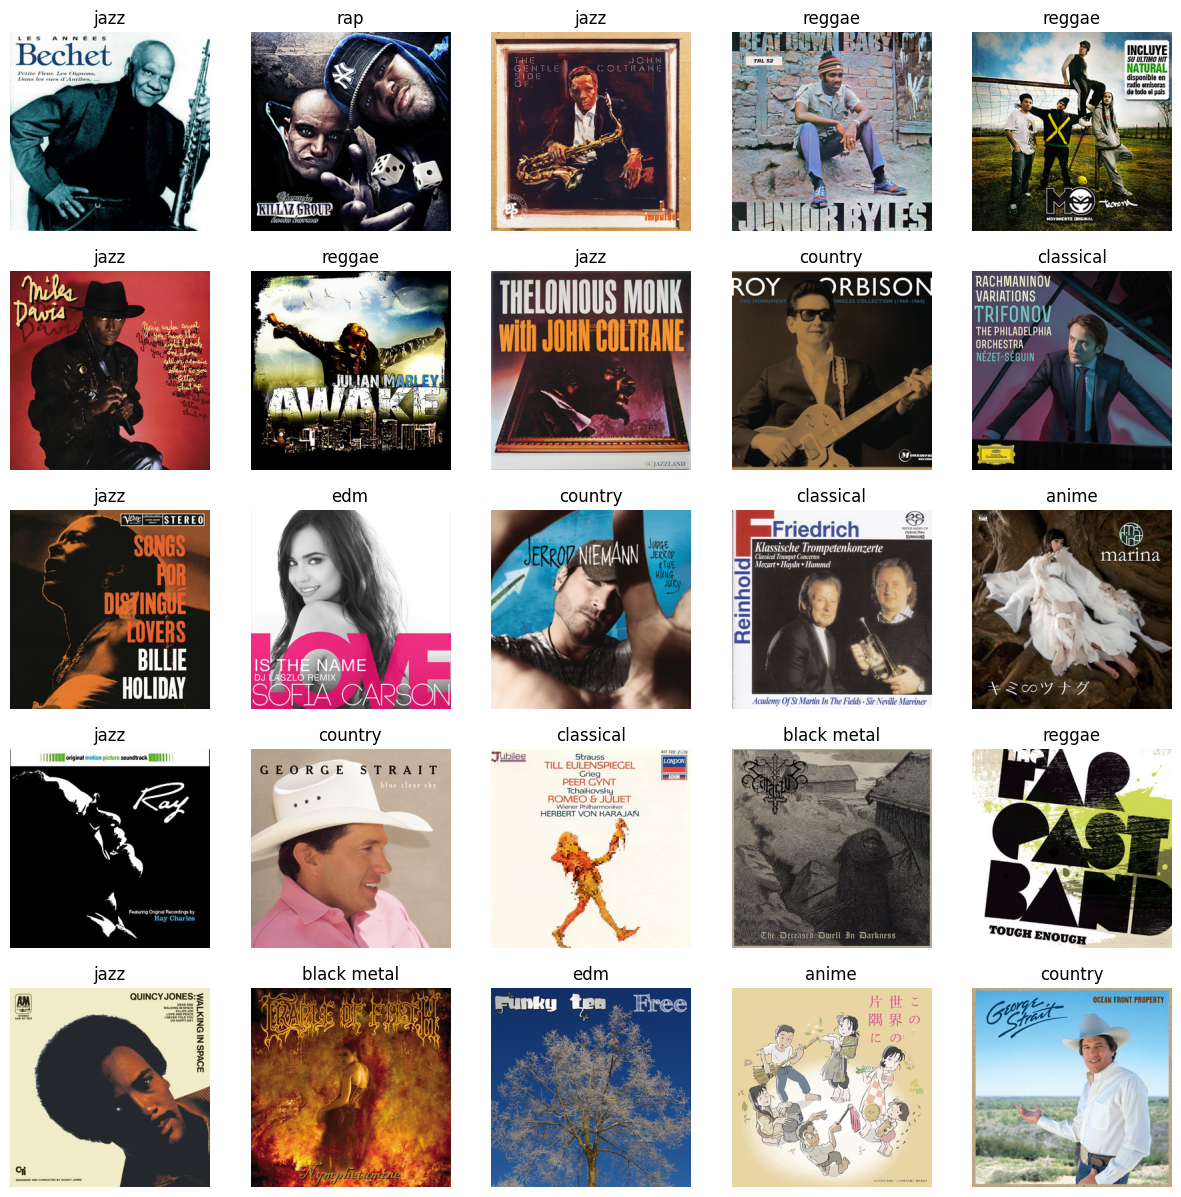

In [17]:
N_IMAGES = 25
sam = df.sample(N_IMAGES)
images = sam['cover']
classes = sam['genre']

plot_images(images, classes)

In [18]:
#Разделим наш датафрейм на трениновочный и тестовый набор, с схоранением структуры классов.
a=df['genre'].value_counts(normalize=True).rename('Full dataset')
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
X = df.drop(['genre'], axis=1)
y = df['genre']
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
  a=pd.concat([a, y.iloc[train_index].value_counts(normalize=True).rename("train")], axis=1)
  a=pd.concat([a, y.iloc[test_index].value_counts(normalize=True).rename("test")], axis=1)
a

,Full dataset,train,test
country,0.190513,0.190427,0.190769
anime,0.152436,0.152479,0.152308
classical,0.122436,0.122393,0.122564
jazz,0.105256,0.105299,0.105128
pop,0.102949,0.102906,0.103077
edm,0.092179,0.092137,0.092308
reggae,0.074487,0.074530,0.074359
disco,0.060000,0.060000,0.060000
black metal,0.057692,0.057778,0.057436
rap,0.042051,0.042051,0.042051


In [19]:
X_train=X.iloc[train_index]
y_train=y.iloc[train_index]
X_test=X.iloc[test_index]
y_test=y.iloc[test_index]

In [20]:
y_train.to_csv('covers.csv')

In [21]:
dd=X_train.iloc[0]['img_embeddings'].shape[1]


In [22]:
X_train.shape

(5850, 2)

In [92]:
#Тестовый набор данных переведём в векторную форму
array_2d = np.concatenate(X_train['img_embeddings'].apply(lambda x: x.flatten()).to_numpy()).reshape(-1, dd)

# Кластеризация данных

In [93]:
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from time import time

In [25]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [94]:
def make_df_2d(df, transfromer):
    data = np.concatenate(df['img_embeddings'].apply(lambda x: x.flatten()).to_numpy()).reshape(-1, dd)
    reduced_data = transfromer.transform(data)
    return  reduced_data

In [95]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")
data = np.concatenate(df['img_embeddings'].apply(lambda x: x.flatten()).to_numpy()).reshape(-1, dd)
kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=df['genre'])

kmeans = KMeans(init="random", n_clusters=10, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=df['genre'])

pca = PCA(n_components=10).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=10, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=df['genre'])

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.677s	3407080	0.584	0.576	0.580	0.443	0.579	0.051
random   	0.155s	3410529	0.566	0.562	0.564	0.411	0.563	0.052
PCA-based	0.068s	3417735	0.605	0.603	0.604	0.504	0.603	0.060
__________________________________________________________________________________


In [96]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=10, n_init=4)
kmeans.fit(reduced_data)

KMeans(n_clusters=10, n_init=4)

In [97]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].


In [98]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In [99]:
kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(float)
kmeans.predict(np.c_[xx.ravel(),yy.ravel()])

array([8, 8, 8, ..., 7, 7, 7])

In [100]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel().astype(int), yy.ravel().astype(int)])

In [101]:
show_labels = {}
num = 1
for i in kmeans.cluster_centers_:
    show_labels[num]=i
    num = num + 1

In [102]:
def show_clusters(df, Z):# Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower"
    )
    genre_data = make_df_2d(df, pca)
    plt.plot(genre_data[:, 0], genre_data[:, 1], "k.", markersize=2)

    a = str(df['genre'].unique()[0])
    plt.title(a)
    for label in show_labels.keys():
        plt.annotate(label, 
                 show_labels[label],
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=18, weight='bold',
                 color = 'w') 
    plt.xticks(())
    plt.yticks(())


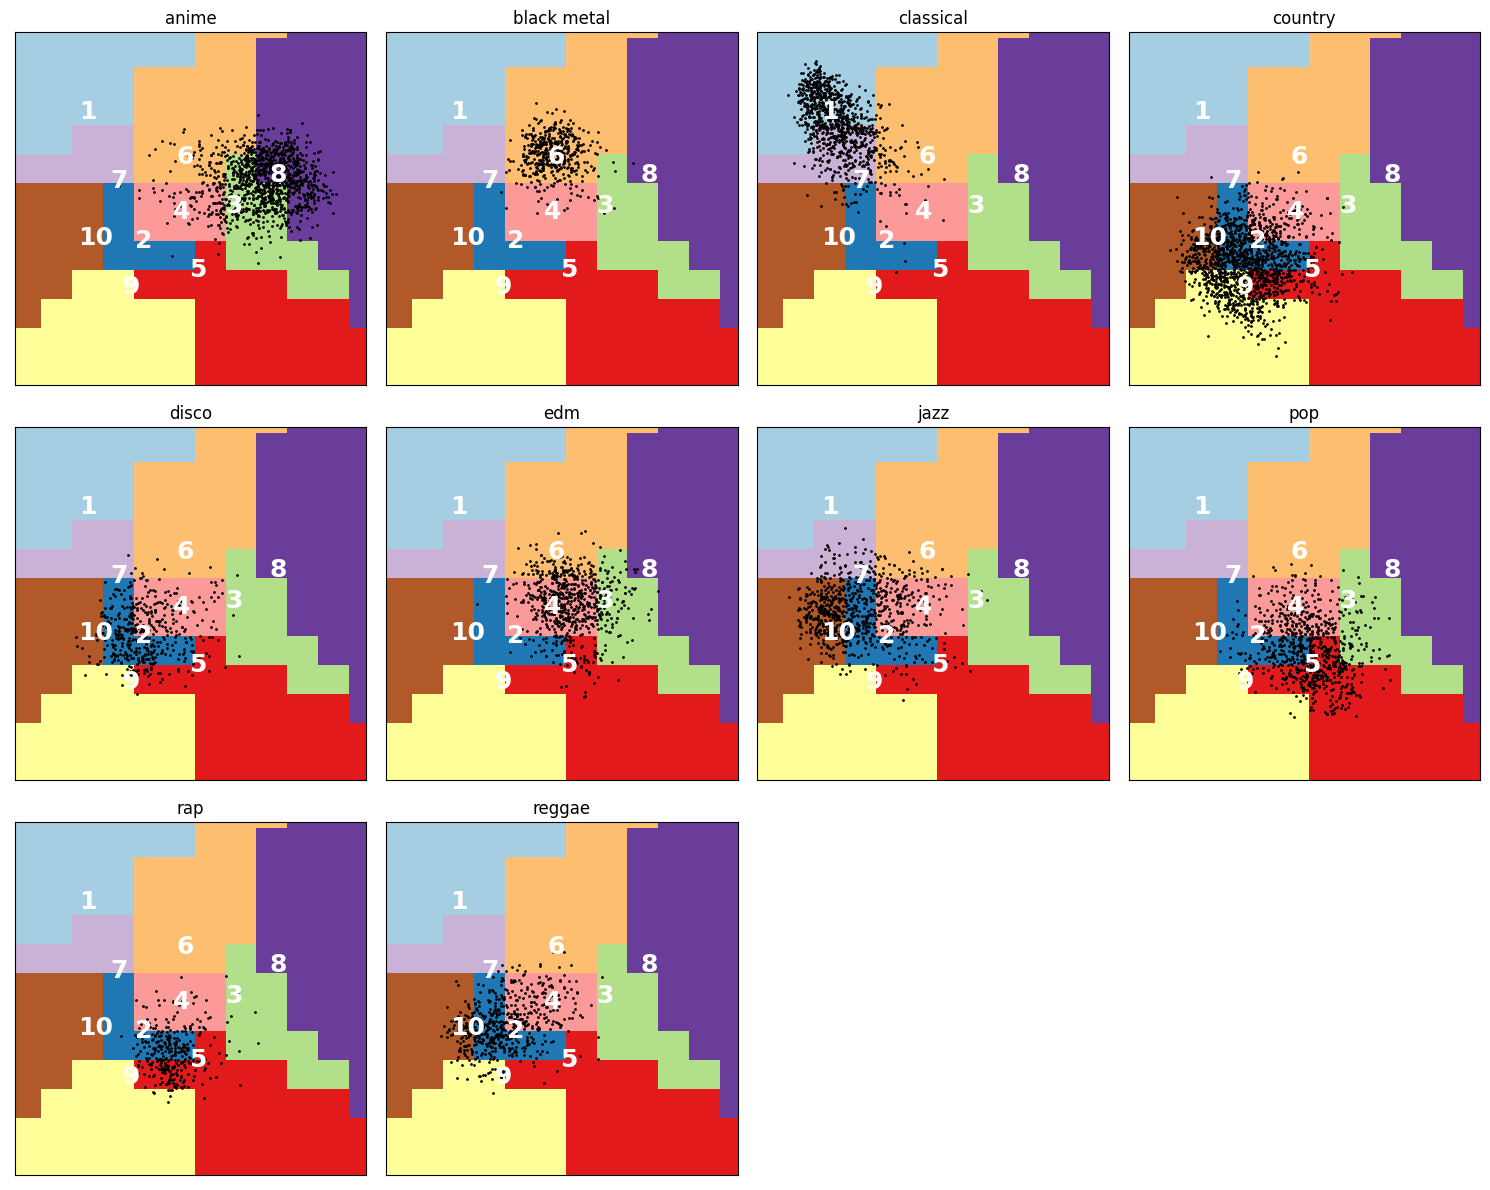

In [103]:
fig = plt.figure(figsize=(15,12))
j = 1
for genre in df['genre'].unique():
    fig.add_subplot(3, 4, j)
    show_clusters(df[df['genre'] == genre], Z)
    j = j + 1
plt.tight_layout()
plt.show()

На графиках видно, что чёткую жанровую принадлежность имеют обложки от classic, anime, balck metal. А вот такие жанры как pop, rap, edm, jazz и disco граздо хуже различимы по обложке. По крайней мере с точки зрения k-means.

In [106]:
df['cluster'] = kmeans.predict(reduced_data.astype(int))

[]

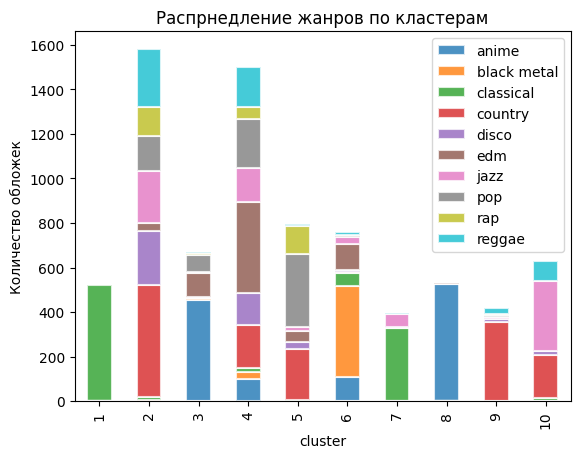

In [107]:
bar_pl = df['genre'].groupby(df['cluster']).value_counts(normalize=False).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)
plt.xticks(range(0, 10), show_labels.keys(), fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Распрнедление жанров по кластерам')
plt.ylabel('Количество обложек')
plt.plot()

In [36]:
index = faiss.IndexFlatL2(dd)
print(index.ntotal)  # пока индекс пустой
index.add(array_2d)
print(index.ntotal)  # теперь в нем вектора

0
5850


In [37]:
# Функция принимает на вход вектор изображения vec, в формета ячейки датафрейма, в которой лежит эмбеддинг, и число  ответов n,а возвращает жанр наиболее часто встречающийся
# среди n обложек альбомов наиболее близких к заданному вектору vec
def find_neighbor(vec,n):
    array_2d_test = vec.reshape(-1, dd)
    D, I = index.search(array_2d_test, n)  # Возвращает результат: Distances, Indices
    #print(I.flatten())
    rez = pd.DataFrame(columns=["genre"])
    for idx in I.flatten():
        rez.loc[ len(rez.index )] = [y_train.iloc[int(idx)]]
    return rez.value_counts(normalize=True).head(1).index[0][0]


In [38]:
#проверим как работает
out=find_neighbor(X_test.iloc[12]['img_embeddings'],5)
print(out)
print('True:',y_test.iloc[12])

classical
True: classical


100%|██████████| 1950/1950 [00:10<00:00, 188.99it/s]


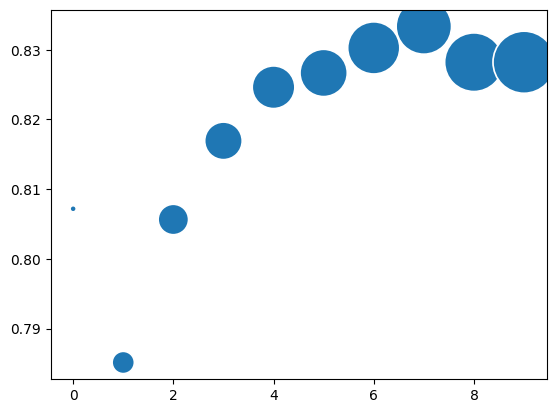

In [39]:

recalls=[]
times=[]
for n_neighbors in range(10):
    start=time()
    pred=[]
    for i in tqdm(X_test['img_embeddings']):
        pred.append(find_neighbor(i,n_neighbors+1))
    recalls.append(recall_score(y_test, pred, average = 'micro'))
    times.append(time()-start)

# use the scatterplot function to build the bubble map
sns.scatterplot(x=range(10), y=recalls, size=times, legend=False, sizes=(20, 2000))

# show the graph
plt.show()

Мы прогнали цикл от 1 до 10 и посмотрели при каком количестве ближайших соседей faiss подбирает категорию жанра точнее всего. Самый лучший результат оказался на 7 соседях.

In [40]:
#Посчитает теперь прогноз по 7 соседям по тестовой выборке
predz=[]
for i in tqdm(X_test['img_embeddings']):
    predz.append(find_neighbor(i,7))

100%|██████████| 1950/1950 [00:08<00:00, 238.59it/s]


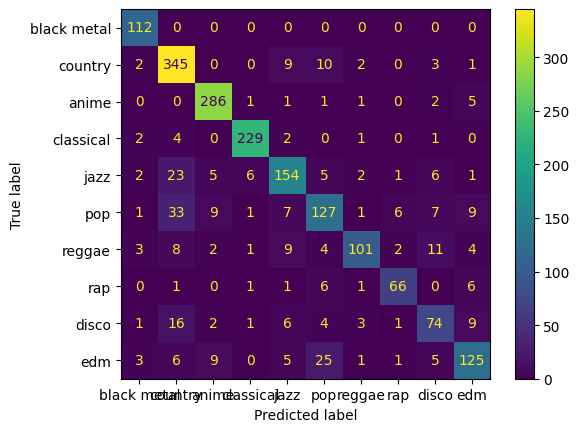

In [41]:
#Построим матрицу ошибок
cm1 = confusion_matrix(y_test, predz, labels=y_test.unique())
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,
                               display_labels=y_test.unique())
disp1.plot()

In [42]:
eva=pd.DataFrame(columns = ['Model','Accuracy','Precission','Recall','F1'])
eva.loc[len(eva.index)] = [
                        'FAISS-baseline',
                        accuracy_score(y_test, predz),
                        precision_score(y_test, predz, average = 'micro'),
                        recall_score(y_test, predz, average = 'micro'),
                        f1_score(y_test, predz, average = 'micro')]
eva

,Model,Accuracy,Precission,Recall,F1
0,FAISS-baseline,0.830256,0.830256,0.830256,0.830256


**Получилось что-то подозрительно точное. Именно здесь я подозреваю утечку целевого признака, но найти её не могу.**

In [113]:

path = r'E:\Data\_Projects\Pet\Music\dataset'

In [114]:
label_function = lambda f: str(f).split("\\")[-2]

In [115]:
covers = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 	   get_items=get_image_files, 
                	   splitter=RandomSplitter(),
                 	    get_y=label_function,
                 	    #item_tfms=Resize(224, method=ResizeMethod.Pad)
                      )

In [116]:
loader = covers.dataloaders(path)

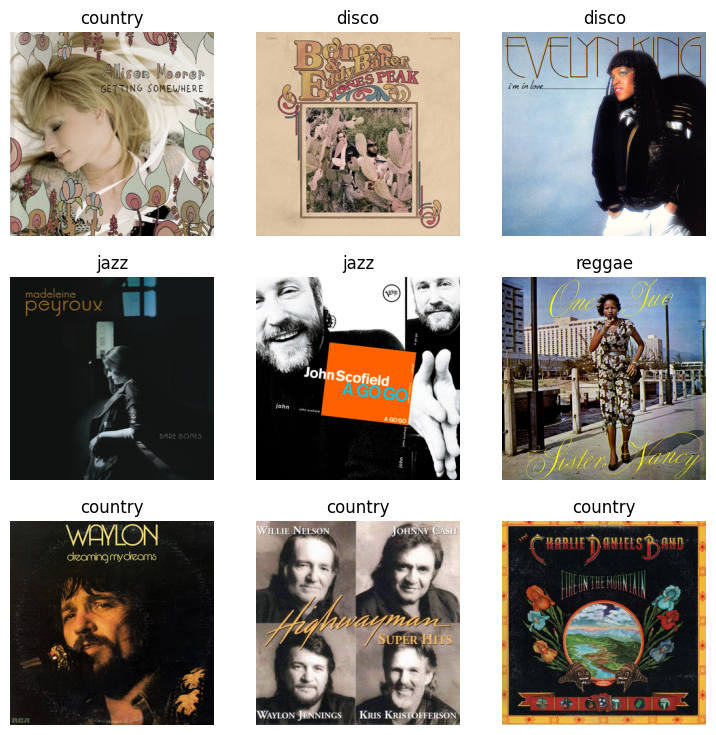

In [117]:
loader.show_batch(max_n=9)

Можно передать в параметре metrics список метрик. 
metrics=[accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')]

In [118]:
learn = vision_learner(loader, models.resnet50, pretrained=True, weights='IMAGENET1K_V2', loss_func=CrossEntropyLossFlat(), ps=0.25,metrics = [accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')])
#learn = vision_learner(loader, 'resnet18', loss_func=CrossEntropyLossFlat(), ps=0.25,metrics = error_rate)

SuggestedLRs(valley=0.0006918309954926372)

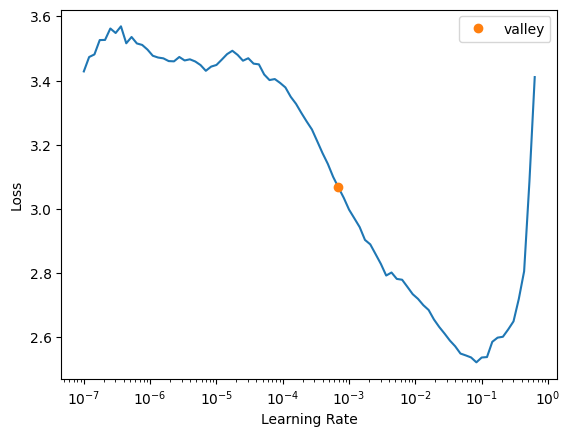

In [119]:
#Подберёмся поближе к хорошей скорости обучения
learn.lr_find()

In [120]:
es=EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=4)
sm=SaveModelCallback(every_epoch=True)
rlr=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.03, patience=2)
rc=Recorder(add_time=True, train_metrics=False, valid_metrics=True,
           beta=0.98)

In [122]:
learn.fine_tune(10, base_lr = 0.0006918309954926372, cbs=[es,sm,rlr])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.753927,1.336922,0.608974,0.605834,0.608974,0.603902,02:28


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.881409,1.151089,0.650000,0.642741,0.650000,0.644212,03:26
1,0.639978,1.154037,0.651282,0.644803,0.651282,0.646357,03:20
2,0.419271,1.170730,0.662821,0.658343,0.662821,0.658534,03:21
3,0.226347,1.172174,0.674359,0.667496,0.674359,0.669251,03:16
4,0.121135,1.197567,0.673718,0.668649,0.673718,0.669197,03:12
5,0.067379,1.242354,0.673718,0.667915,0.673718,0.668316,03:04
6,0.043794,1.247588,0.678846,0.671950,0.678846,0.673951,03:20
7,0.032428,1.261972,0.687180,0.681982,0.687179,0.682385,03:11
8,0.023968,1.257910,0.694231,0.688592,0.694231,0.689869,03:08
9,0.021846,1.259451,0.687180,0.681566,0.687179,0.681754,03:08


Epoch 2: reducing lr to 3.459074341328126e-05
Epoch 4: reducing lr to 2.814202843998528e-05
Epoch 6: reducing lr to 1.352537164644083e-05
Epoch 8: reducing lr to 1.7480365821197393e-06


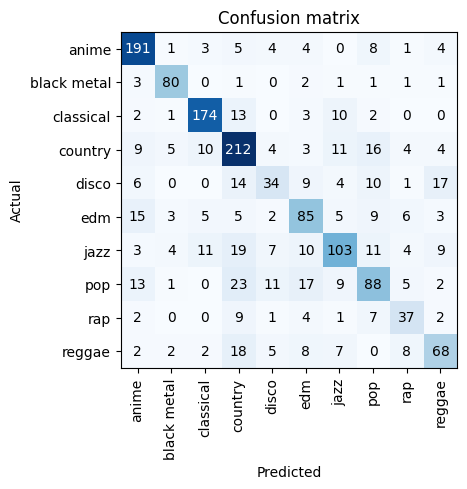

In [123]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [124]:
preds,targs = learn.get_preds()

In [125]:
preds=preds.numpy()
targs=targs.numpy()
preds=np.argmax(preds, axis=1)
preds

array([7, 2, 6, ..., 2, 9, 7], dtype=int64)

In [126]:
eva.loc[len(eva.index)] = [
                        'resnet50-10EPOCHS',
                        accuracy_score(targs, preds),
                        precision_score(targs, preds, average = 'micro'),
                        recall_score(targs, preds, average = 'micro'),
                        f1_score(targs, preds, average = 'micro')]
eva

,Model,Accuracy,Precission,Recall,F1
0,FAISS-baseline,0.830256,0.830256,0.830256,0.830256
1,resnet50,0.659615,0.659615,0.659615,0.659615
2,resnet50-10EPOCHS,0.687179,0.687179,0.687179,0.687179


Вывод:
1. Попытки кластеризации набора данных показали, что лишь небольшая часть жанров, обладает самобытными обложками. 
2. Несмотря на это, удалось построить индекс на основе FAISS, который позволил достаточно точно (83% случаев) правильно определять жанр, на тестовом наборе данных.
3. Нейростеть на основе fastai, несмотря на значительно более долгие сроки обучения, не смогла предложить подобную точность, да и по итогам оказалась слишком громозкой, чтобы быть развёрнутой в облаке streamlit.
4. Предикативная система на основе faiss удалось разместить в облаке streamlit и она даже более-менее стабильно работает по ссылке, хотя я и не смог запустить с мобильника.